In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import *
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")

# Calculate features

In [5]:
def compute_features(df):
    # intraday return features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17res'
    features = temp.reset_index()

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # 17:30 ma raw return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3raw'] = features['17ma1raw'] - features['17ma3raw']
    features['17ma1-5raw'] = features['17ma1raw'] - features['17ma5raw']
    features['17ma1-20raw'] = features['17ma1raw'] - features['17ma20raw']

    # 17:30 ma residual return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3res'] = features['17ma1res'] - features['17ma3res']
    features['17ma1-5res'] = features['17ma1res'] - features['17ma5res']
    features['17ma1-20res'] = features['17ma1res'] - features['17ma20res']

    # market value
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id') * df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'market_value'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # intraday volume features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='16:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') - df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')) / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # turnover ma
    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma1'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma3'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma5'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma20'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # original features 
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='estVol winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'estVol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid16'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid10'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'vol17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # Normalization
    #features.iloc[:,2:] = (features.iloc[:,2:] - features.iloc[:,2:].mean())/features.iloc[:,2:].std()

    # Merging with target
    target = df[df["Time"] == "17:30:00.000"][['Date','Id','ResidualNoWinsorCumReturn winsorized']].copy()
    merged = features.merge(target ,on =['Date','Id']).drop_duplicates()
    merged = merged.sort_values(['Id','Date'],ascending = [True, True])
    merged["y"] = merged.groupby(['Id'])["ResidualNoWinsorCumReturn winsorized"].shift(-1)
    merged = merged.dropna(how = 'any')
    merged = merged.sort_values('Date',ascending=True)
    merged_with_dates = merged
    merged_with_dates.to_csv("merged_with_dates.csv")
    merged = merged.drop(["Id", "Date","ResidualNoWinsorCumReturn winsorized"], axis = 1)
    merged.to_csv('beforeTrainning.csv')
    return merged, merged_with_dates

In [26]:
# df = pd.read_csv(r"C:\Users\Lenovo\Python workshop\project\merged_data_fillna_timeid.csv", sep = ",")
# m, mwd = compute_features(df)

# df2 = pd.read_csv(r"C:\Users\Lenovo\Python workshop\project\test_merged_data.csv", sep = ",")
# m2, mwd2 = compute_features(df2)

In [28]:
path1 = r"C:/Users/Lenovo/Python workshop/project/features20140101_20190101.csv"
path2 = r"C:/Users/Lenovo/Python workshop/project/merged_data20140101_20190101.csv"

m1 = pd.read_csv(path1)
m2 = pd.read_csv(path2)

In [29]:
m1.head()

,Unnamed: 0,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,17ma1-3raw,...,turnover_ma1,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,y
0,19,-0.014479,0.004383,0.003725,0.001532,-0.002551,-0.004328,0.012658,0.001606,0.001777,...,5127.454439,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,-0.017619
1,640523,0.022158,0.036882,-0.014741,-0.022160,-0.013064,-0.003323,-0.010847,-0.008666,-0.009740,...,3560.886066,2510.740303,2581.035432,2202.298241,0.295619,2.644472,2.586516,2.743826,2096023.0,-0.007371
2,641193,0.017659,0.039312,0.005400,-0.004994,-0.029892,-0.012260,-0.017550,-0.005108,-0.017632,...,7968.631599,6221.639520,6135.606623,4995.747522,0.204733,42.970676,42.970676,44.917362,1062115.0,0.009531
3,643130,0.006544,0.019172,0.001098,-0.002364,-0.013599,-0.004222,-0.015091,-0.002486,-0.009377,...,4172.375545,3466.191410,3757.401356,2936.059761,0.178838,17.535980,17.494583,17.875440,4175388.0,-0.000857
4,645403,0.007003,0.021363,0.002370,0.001177,-0.018284,-0.000653,0.000158,-0.004395,-0.017631,...,1364.178894,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,0.005427


In [30]:
m2.head()

,Date,Time,Id,ResidualNoWinsorCumReturn,RawNoWinsorCumReturn,estVol,SharesOutstanding,MDV_63,CleanMid,CumVolume,IsOpen,ResidualNoWinsorCumReturn winsorized,RawNoWinsorCumReturn winsorized,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized
0,20140501,10:00:00.000,IDZQ0005R34,-0.001395,0.006989,0.161224,575.375,3047253.2,6.309242,32011.0,1.0,-0.001395,0.006989,0.161224,575.375,3.047253e+06,6.309242,32011.0
1,20140501,10:00:00.000,IDZQ0008WW8,0.002370,0.003549,0.260051,1308.352,37487736.0,7.395002,52478.0,1.0,0.002370,0.003549,0.260051,1308.352,3.748774e+07,7.395002,52478.0
2,20140501,10:00:00.000,IDZQ000FLJ9,-0.002061,0.003142,0.146437,681.888,24390608.0,13.468503,20092.0,1.0,-0.002061,0.003142,0.146437,681.888,2.439061e+07,13.468503,20092.0
3,20140501,10:00:00.000,IDZQ000QHK4,-0.003114,-0.005089,0.108171,2112.072,227479360.0,32.293990,480379.0,1.0,-0.003114,-0.005089,0.108171,2112.072,1.377412e+08,32.293990,480379.0
4,20140501,10:00:00.000,ID000BC8564,-0.002370,0.003301,0.146089,271.109,11127688.0,30.773079,11587.0,1.0,-0.002370,0.003301,0.146089,271.109,1.112769e+07,30.773079,11587.0


In [31]:
train = m1.loc[m1["Unnamed: 0"].isin(m2[m2["Date"] < 20170101].index)] # 2014-2016
valid = m1.loc[m1["Unnamed: 0"].isin(m2[(m2["Date"] >= 20170101) & m2["Date"] < 20180101].index)] # 2017
test = m1.loc[m1["Unnamed: 0"].isin(m2[m2["Date"] >= 20180101].index)] # 2018

train.head()

,Unnamed: 0,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,17ma1-3raw,...,turnover_ma1,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,y
0,19,-0.014479,0.004383,0.003725,0.001532,-0.002551,-4.328447e-03,0.012658,0.001606,0.001777,...,5127.454439,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,-0.017619
4,645403,0.007003,0.021363,0.002370,0.001177,-0.018284,-6.530792e-04,0.000158,-0.004395,-0.017631,...,1364.178894,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,0.005427
5,646684,0.000216,0.014031,0.003584,-0.001199,-0.008458,-5.796803e-03,-0.004567,0.005816,-0.002661,...,1991.979684,1418.626035,1253.361174,1755.174041,0.255014,8.605063,8.594749,8.726646,882447.0,0.022712
6,647030,-0.004470,0.003925,0.000464,0.004713,0.003613,2.770046e-03,-0.000759,0.001068,0.000843,...,1071.451561,964.059650,791.824911,749.316061,0.136685,189.779941,189.779941,189.779941,6658.0,-0.007399
7,647403,-0.009049,0.006995,-0.003221,-0.005797,0.006212,-1.123333e-08,-0.007774,-0.000509,0.006212,...,1544.120471,1322.711271,1227.455657,1456.009146,0.198565,20.052948,19.937037,20.193700,305566.0,-0.001233


# Feature selection

In [32]:
keep_var = ['10/17res', '10/17raw', '16/17res', '16/17raw', '17ma3raw', '17ma3res',
       '17ma5res', 'market_value', '10/17vol', '16/17vol', 'turnover_ma1',
       'turnover_ma20', 'estVol', 'cleanMid17', 'vol17', 'y']

In [33]:
train = train.loc[:,keep_var]
valid = valid.loc[:,keep_var]
test = test.loc[:,keep_var]

train.shape, valid.shape, test.shape

((570934, 16), (954971, 16), (218626, 16))

# Train-valid-test split

In [34]:
X_train, y_train = train.iloc[: , :-1].reset_index(drop=True), train["y"].reset_index(drop=True)
X_valid, y_valid = valid.iloc[: , :-1].reset_index(drop=True), valid["y"].reset_index(drop=True)
X_out, y_out = test.iloc[: , :-1].reset_index(drop=True), test["y"].reset_index(drop=True)

In [35]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_out.shape, y_out.shape

((570934, 15), (570934,), (954971, 15), (954971,), (218626, 15), (218626,))

In [36]:
def weighted_mse(model, y_true, X):
    r2_weight = 1 / np.array(X['estVol'])
    r2_weight = r2_weight / r2_weight.sum()
    y_pred = model.predict(X)
    return r2_score(y_true, y_pred, sample_weight = r2_weight)

def model_fit(model, X_train, y_train, X_valid, y_valid, X_test, y_test, early_stopping_rounds = 50, eval_metric = 'logloss'):
    
    # Fit the algorithm on the data
    if early_stopping_rounds!=0:
        model.fit(X_train, y_train, eval_metric=eval_metric, 
                     early_stopping_rounds = early_stopping_rounds,
                     eval_set=[(X_valid, y_valid)], verbose=False)
    else:
        model.fit(X_train, y_train, eval_metric=eval_metric)       
  

    # calculate weighted r2
    weight_r2_train = weighted_mse(model, y, X)
    weight_r2_valid = weighted_mse(model, y_valid, X_valid)
    weight_r2_test = weighted_mse(model, y_test, X_test)

    #Print model report:
    print("\nModel Report")
    print(f"train r2: {weight_r2_train*100}%, valid r2: {weight_r2_valid*100}%, test r2: {weight_r2_test*100}%")
    return model

# Model fit, summary

In [40]:
best_paras = { 'max_depth': 4,
                    'min_child_weight':5,
                    'n_estimators': 100,
                    'gamma': 0,
                    'learning_rate': 0.1} 

In [41]:
my_model = XGBRegressor()
my_model.set_params(**best_paras)  
my_model = model_fit(my_model, X_train, y_train, 
                    X_valid, y_valid,
                    X_out, y_out, early_stopping_rounds = 50, eval_metric = 'mphe')


Model Report
train r2: -0.6817786042304652%, valid r2: -0.7934505094298494%, test r2: -0.9304817641124563%


In [38]:
best_paras = {'learning_rate': 0.05,
              'num_leaves': 24,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.8,
              'max_depth': 5}

In [39]:
my_model = LGBMRegressor()
my_model.set_params(**best_paras)  
my_model = model_fit(my_model, X_train, y_train, 
                    X_valid, y_valid,
                    X_out, y_out, early_stopping_rounds = 50, eval_metric = 'mphe')


Model Report
train r2: 0.41977544856580673%, valid r2: 0.31530302817327494%, test r2: 0.15576217689285965%


# Plots

# binplot

###  y vs y_pred

In [1]:
y_pred = my_model.predict(X_test)  
ans = pd.DataFrame.from_dict({'y_pred': y_pred, 'y': y_test})
ans.to_csv('predictions.csv',index=False)    

NameError: name 'my_model' is not defined

In [60]:
def bin_plot(df, x_label, y_label, n_bins, path, w_label=None, scale=1, ax=None, **plot_kwargs):
        
        '''
        create a bin plot with your feature (x_label), binned into (num_bin) quantiles 
        (with equal count), on the X-axis, and the corresponding mean of the target
        variable (y_label) along with one standard error around mean on the Y-axis. 
        
        Parameters
        ----------------
        x_label: str
            label of feature x
            
        y_label: str
            label of target
            
        w_label: str
            label of weight if provided
            
        scale: float, default=1
            where to plot the point with the bin = mean(bin) * scale
            
        ax: axes
            ax to plot on, if None, the function will create one
            
        n_bins: int
            number of bins
            
        **plot_kwargs: dict
            keyword and arguments of ax.plot(x, y)
        '''
        
        key = df[x_label].values
        value = df[y_label].values
        if w_label is not None:
            w = df[w_label].values
        
            
        sorted_idx = np.argsort(key)
        chunks = np.array_split(sorted_idx, n_bins)
              
        # x axis on the plot: bin mean
        x = np.ones(n_bins)
        # boundary of the bins
        b = np.ones(n_bins)
        # y axis on the plot: bin mean
        y = np.ones(n_bins)
        # confidence of y: bin std
        c = np.ones(n_bins)
        
        for bin_idx, idx in enumerate(chunks):
            
            x[bin_idx] = np.mean(key[idx]) * scale
            b[bin_idx] = np.max(key[idx])
            if w_label is not None:
                y[bin_idx] = np.average(value[idx], weights=w[idx])
            else:
                y[bin_idx] = np.mean(value[idx])
            c[bin_idx] = np.std(value[idx]) / np.sqrt(len(value[idx]))
        
        if ax is None: 
            fig, ax = plt.subplots(figsize=(10, 6))
            
        ymin = np.min(y-c) - 0.5 * abs(np.min(y-c))
        ymax = np.max(y+c) + 0.5 * abs(np.max(y-c))
            
        ax.plot(x, y, 'o-', **plot_kwargs)
        ax.fill_between(x, y-c, y+c, color='b', alpha=0.1)
        ax.vlines(b[:-1], ymin=ymin, ymax=ymax, color='grey')
        ax.set_xticks(b[:-1])
        ax.set_ylim(bottom=ymin, top=ymax)
        ax.set_xlabel('bin boundaries, based on quantiles of {:s}'.format(x_label))
        ax.set_ylabel('within-bin means and 1 std error of {:s}'.format(y_label))
        ax.set_title('{:d} binned plot of {:s} against {:s}'.format(n_bins, y_label, x_label))
        
        fig.savefig(path+'bin_plot_'+x_label.replace('/','_')+'.png')

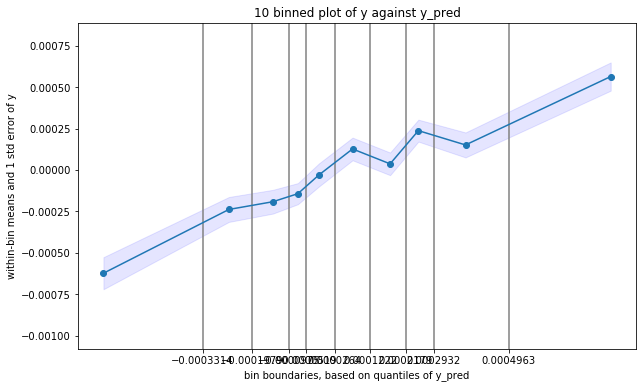

In [61]:
path = r'C:\\Users\\Lenovo\\Desktop\\2022Spring\\9899 Machine learning\\project\\latex\\'
bin_plot(ans, 'y_pred', 'y', 10, path, w_label=None, scale=1)

### y vs feature

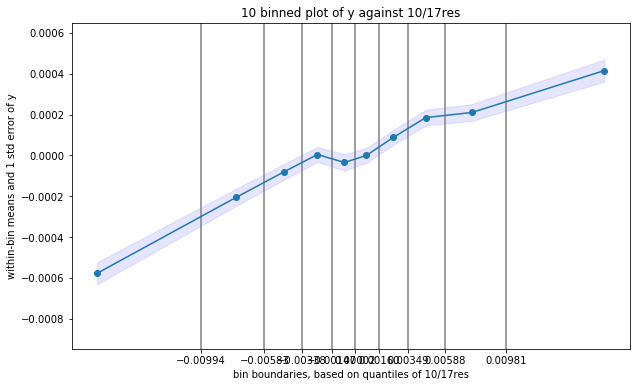

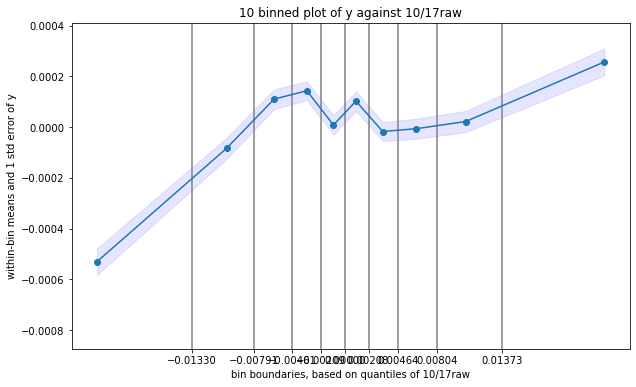

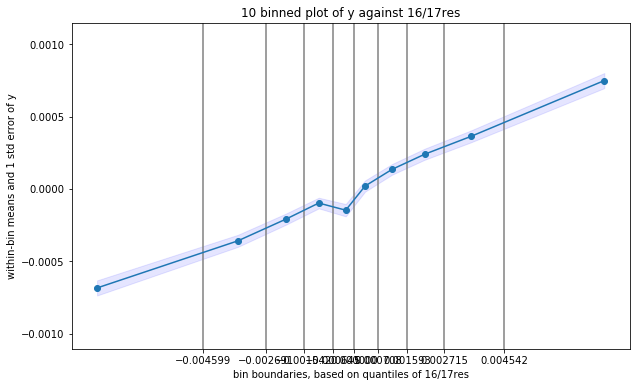

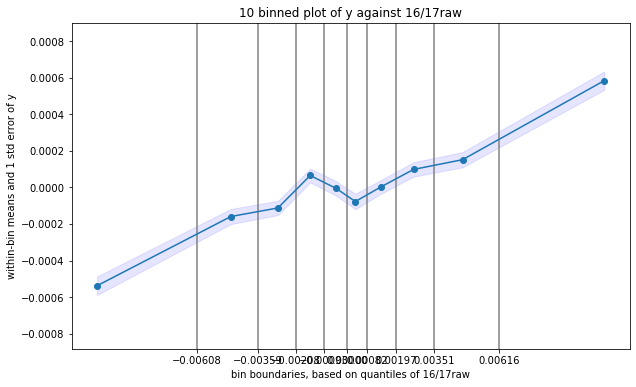

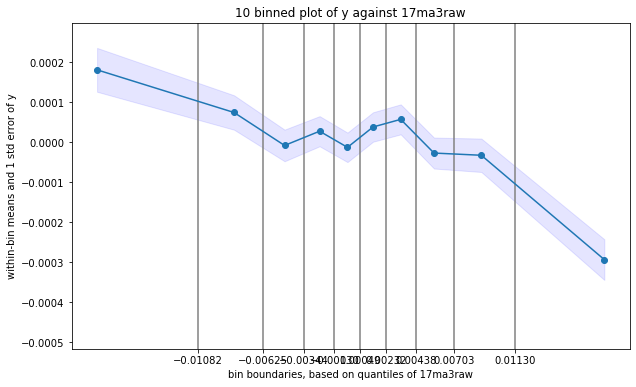

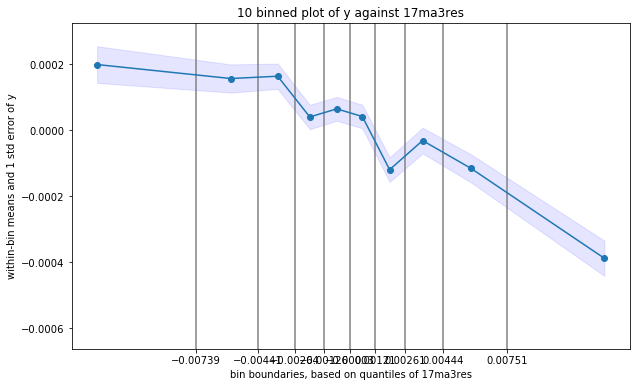

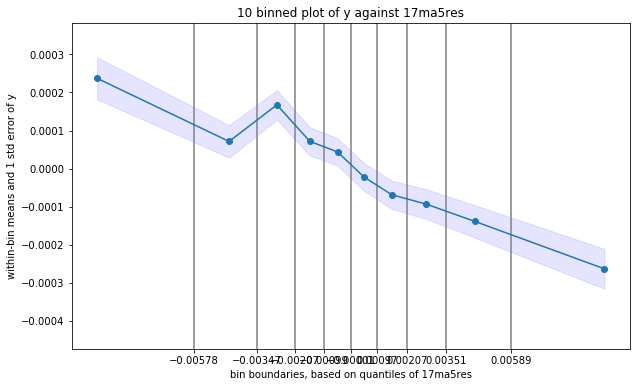

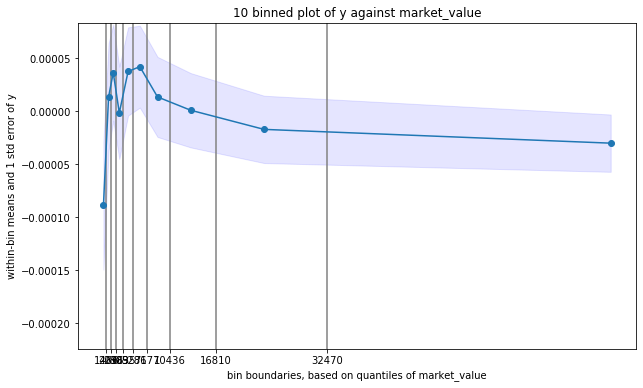

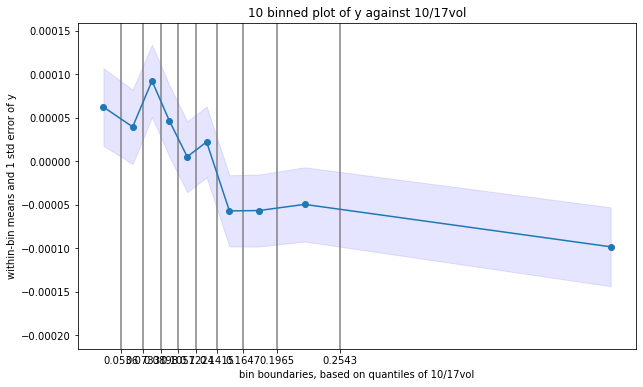

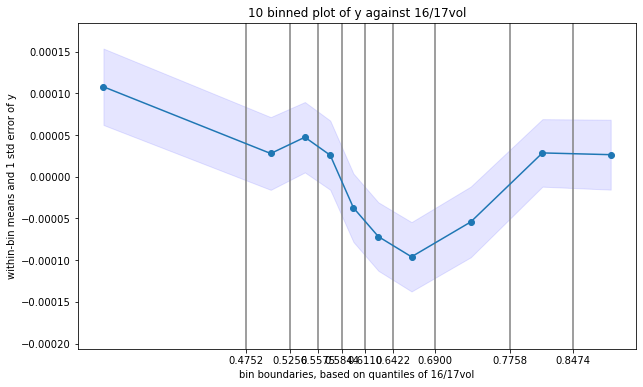

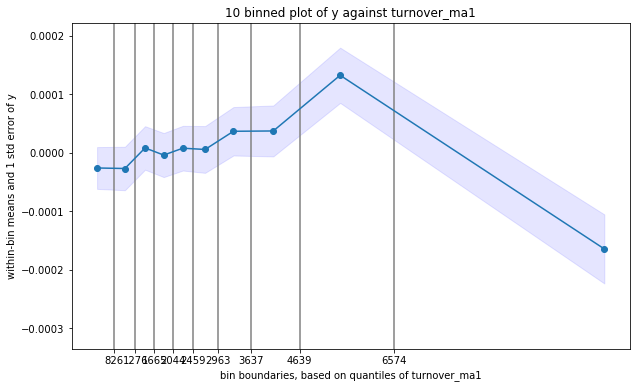

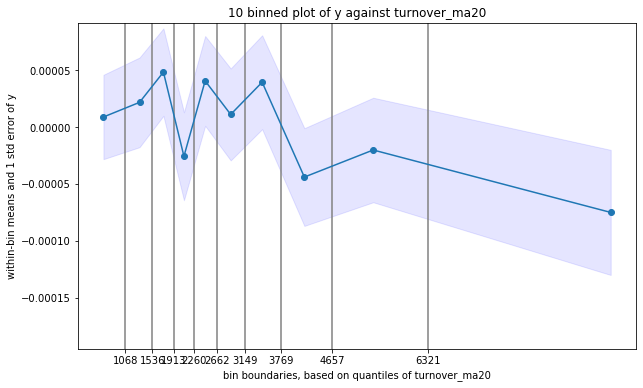

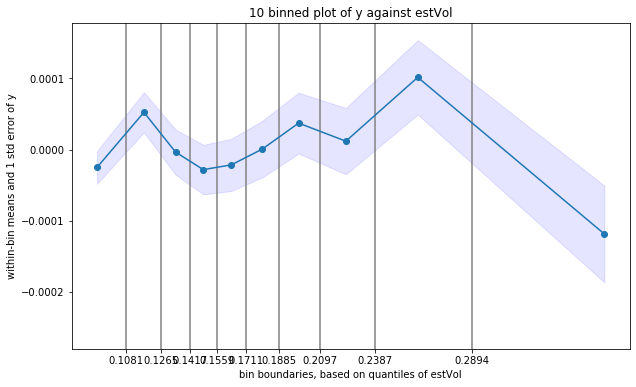

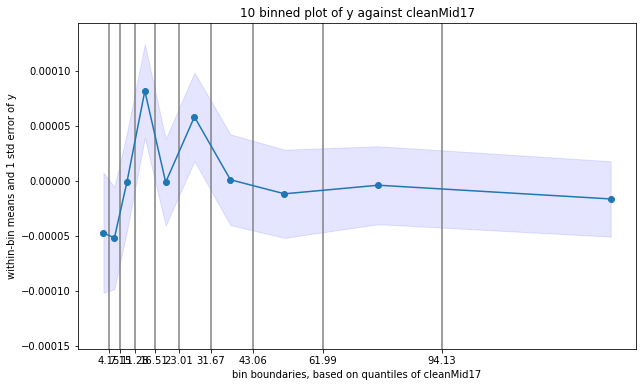

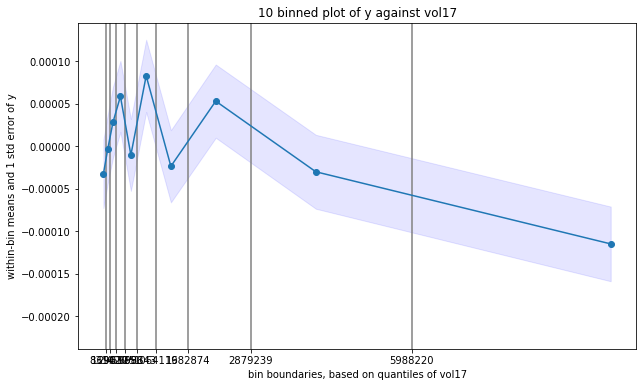

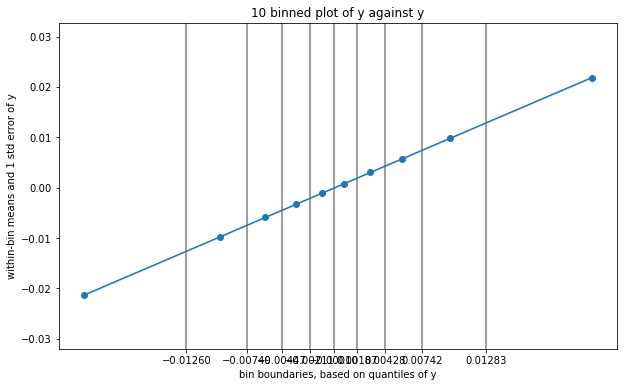

In [62]:
for col in m.columns:
    bin_plot(m, col, 'y', 10, path, w_label=None, scale=1)    

## Drift plot